In [1]:
import random
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import  tensorflow.keras.backend as k
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from sklearn import decomposition

In [2]:
tf.__version__

'2.0.0'

In [3]:
#load data
(x_train,y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.
x_train /= 255
x_test /= 255


In [4]:
def make_pairs(x,y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    pairs = []
    labels = []
    for i in range(len(x)):
        x1 = x[i]
        label1 = y[i]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        pairs += [[x1,x2]]
        labels += [1]
        
        #add a not matching 
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)
        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
            
        pairs += [[x1,x2]]
        labels += [0]
    return np.array(pairs), np.array(labels)
            

In [5]:
pairs_train, labels_train = make_pairs(x_train, y_train)
pairs_test, labels_test = make_pairs(x_test, y_test)

In [6]:
print(pairs_train.shape, labels_train.shape)
print(pairs_test.shape, labels_test.shape)

(120000, 2, 28, 28) (120000,)
(20000, 2, 28, 28) (20000,)


0


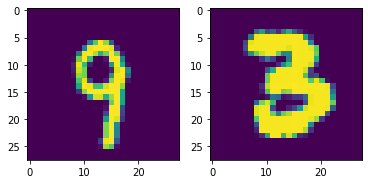

In [7]:
#plot pairs
idx = random.randint(0, pairs_train.shape[0])


fig = plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(pairs_train[idx,0])

plt.subplot(1, 2, 2)
plt.imshow(pairs_train[idx,1])
# zero m√©ans the pairs are not the same while one means vice versa
print(labels_train[idx])

In [8]:
def euclidean_distance(vects):
    x,y = vects
    sum_square = k.sum(k.square(x-y), axis=1, keepdims=True)
    sqrt = k.sqrt(k.maximum(sum_square, k.epsilon()))
    return sqrt

In [9]:
# create model
input = Input((28,28))
x = Flatten()(input)
x = Dense(10) (x)
x = Dense(128, activation='relu')(x)
dense = Model(input, x)

input1 = Input((28,28))
input2 = Input((28,28))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = Lambda(euclidean_distance)([dense1,dense2])
dense_layer = Dense(1, activation='sigmoid')(merge_layer)
model = Model (inputs = [input1,input2], outputs = dense_layer)

In [10]:
model.compile(loss ='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

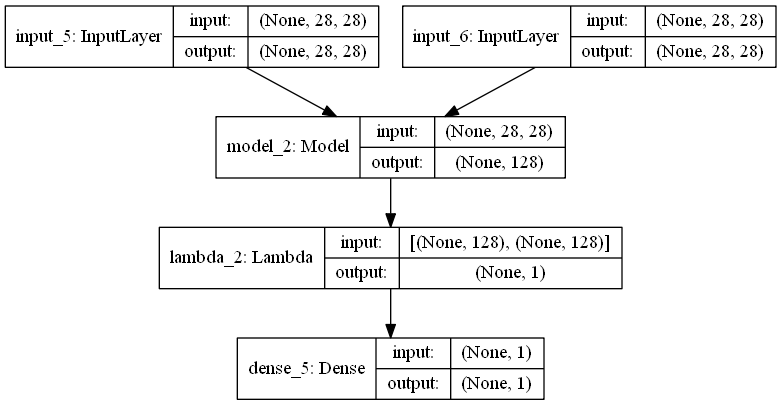

In [12]:
model.fit([pairs_train[:,0],pairs_train[:,1]], labels_train[:], batch_size=32, epochs=20)

Train on 120000 samples
Epoch 1/20
120000/120000 [==============================] - 9s 71us/sample - loss: 0.4482 - accuracy: 0.7945
Epoch 2/20
120000/120000 [==============================] - 6s 54us/sample - loss: 0.3009 - accuracy: 0.8863
Epoch 3/20
120000/120000 [==============================] - 7s 57us/sample - loss: 0.2567 - accuracy: 0.9011
Epoch 4/20
120000/120000 [==============================] - 6s 52us/sample - loss: 0.2328 - accuracy: 0.9098
Epoch 5/20
120000/120000 [==============================] - 7s 58us/sample - loss: 0.2171 - accuracy: 0.9174
Epoch 6/20
120000/120000 [==============================] - 7s 57us/sample - loss: 0.2073 - accuracy: 0.9206
Epoch 7/20
120000/120000 [==============================] - 7s 58us/sample - loss: 0.2012 - accuracy: 0.9231
Epoch 8/20
120000/120000 [==============================] - 6s 52us/sample - loss: 0.1955 - accuracy: 0.9252
Epoch 9/20
120000/120000 [==============================] - 6s 53us/sample - loss: 0.1909 - accuracy: 0.


## Visualizing Weights using the PCA

Using the PCA, I can graphically represent high dimensional embeddings. This can be helpful in visualizing, examining, and understanding your embedding layers.


In [13]:
# Get the weights of the embedding layer
weights = tf.Variable(dense.layers[3].get_weights()[0])
print(weights.shape)

(10, 128)


In [14]:
# n_components = numbers of dimenstions you want to retain
pca = decomposition.PCA(n_components=2)
pca_data = pca.fit_transform(weights.numpy())


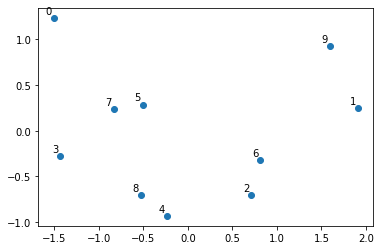

In [15]:
# plot weights
names = [str(i) for i in range(10)]
plt.scatter(pca_data[:,0],pca_data[:,1])
for label, x, y in zip(names, pca_data[:,0], pca_data[:,1]):
    plt.annotate( label, xy=(x, y), xytext=(-2, 2), textcoords='offset points', ha='right', va='bottom' )
plt.show()

# Evaluate Model on the test dataset

In [16]:
score, acc = model.evaluate([pairs_test[:,0],pairs_test[:,1]], labels_test[:],batch_size=25, verbose=2)
print('Test score:', score) #Score is the evaluation of the loss function for a given input.
print('Test accuracy:', acc)

20000/1 - 1s - loss: 0.1378 - accuracy: 0.9208
Test score: 0.20599256379064174
Test accuracy: 0.92085


# Test Model on the Fashion MNIST dataset

In [17]:
(f_x_train, f_y_train), (f_x_test, f_y_test)= tf.keras.datasets.fashion_mnist.load_data()
f_x_train = f_x_train.astype('float32')
f_x_test = f_x_test.astype('float32')
f_x_train /= 255
f_x_test /= 255

In [18]:
num_classes = max(f_y_train) + 1
digit_indices = [np.where(f_y_train == i)[0] for i in range(num_classes)]

f_idx = random.randint(0, num_classes-1)
pair1 = f_x_train[random.choice(digit_indices[f_idx])]
pair2 = f_x_train[random.choice(digit_indices[f_idx])]

(28, 28)


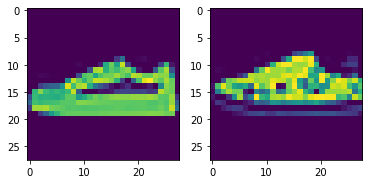

In [19]:
# plot pairs
fig = plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(pair1)

plt.subplot(1, 2, 2)
plt.imshow(pair2)


print(pair1.shape)

In [20]:
input1 = np.expand_dims(pair1,0)
input2 = np.expand_dims(pair2,0)

In [21]:
#make prediction
model.predict([input1,input2])

array([[0.04019182]], dtype=float32)

# Evaluate on The Fashion MNIST dataset

In [22]:
fashion_x_test, fashion_y_test = make_pairs(f_x_test,f_y_test)
print(fashion_x_test.shape)
print(fashion_y_test.shape)

(20000, 2, 28, 28)
(20000,)


In [23]:
score, acc = model.evaluate([fashion_x_test[:,0],fashion_x_test[:,1]], fashion_y_test[:],batch_size=16, verbose=2)
print('Test score:', score) #Score is the evaluation of the loss function for a given input.
print('Test accuracy:', acc)

20000/1 - 1s - loss: 2.3835 - accuracy: 0.5568
Test score: 2.6629325595855713
Test accuracy: 0.5568
